# Netflix Views EDA (with embedded charts)

This notebook loads **Netflix Movies and TV Shows.mht**, cleans the data, and runs EDA with charts. The notebook is saved **with outputs**, so plots are visible when you open it.


In [1]:
# Imports and plotting style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120


In [2]:
# Load .mht -> extract largest HTML table -> dataframe
from bs4 import BeautifulSoup
import re

mht_path = 'Netflix Movies and TV Shows.mht'
with open(mht_path, 'r', encoding='utf-8', errors='ignore') as f:
    mht_text = f.read()

html_match = re.search(r'(?is)(<html.*)</html>', mht_text)
html_text = html_match.group(0) if html_match else mht_text

soup = BeautifulSoup(html_text, 'html.parser')
tables = soup.find_all('table')

def table_cell_count(tbl):
    return len(tbl.find_all(['td', 'th']))

if len(tables) == 0:
    raise ValueError('No HTML tables found in the MHT file.')

largest_table = sorted(tables, key=table_cell_count, reverse=True)[0]

netflix_df = pd.read_html(str(largest_table))[0].copy()
netflix_df.columns = [str(c).strip() for c in netflix_df.columns]

netflix_df['date'] = pd.to_datetime(netflix_df['date'], errors='coerce')
netflix_df['Views'] = pd.to_numeric(netflix_df['Views'], errors='coerce')

netflix_df.head()

/tmp/ipykernel_386/3727395030.py:23: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  netflix_df = pd.read_html(str(largest_table))[0].copy()


,date,Views
0,2025-12-14,1551
1,2025-12-15,1707
2,2025-12-16,1795
3,2025-12-17,1822
4,2025-12-18,1561


### Data overview
We check the dataset size, data types, and missing values. This validates parsing and informs what cleaning is needed.

In [3]:
print(netflix_df.shape)
print(netflix_df.dtypes)
print(netflix_df.isna().sum())

(29, 2)
date     datetime64[ns]
Views             int64
dtype: object
date     0
Views    0
dtype: int64


### Cleaning
We drop exact duplicate rows (if any) and inspect outliers using both IQR and z-score rules. We do *not* automatically remove outliers unless they are obvious errors.

In [4]:
# Duplicates
dup_count = netflix_df.duplicated().sum()
netflix_df_clean = netflix_df.drop_duplicates().copy()
print('Duplicate rows:', int(dup_count))
print('Rows after de-dup:', int(netflix_df_clean.shape[0]))

# Outliers (IQR)
q1 = netflix_df_clean['Views'].quantile(0.25)
q3 = netflix_df_clean['Views'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_iqr = netflix_df_clean.loc[
    (netflix_df_clean['Views'] < lower_bound) | (netflix_df_clean['Views'] > upper_bound),
    ['date','Views']
].sort_values('Views')

print('IQR lower bound:', float(lower_bound))
print('IQR upper bound:', float(upper_bound))
print(outliers_iqr)

Duplicate rows: 0
Rows after de-dup: 29
IQR lower bound: 418.5
IQR upper bound: 2134.5
Empty DataFrame
Columns: [date, Views]
Index: []


### Feature engineering
We add day-of-week and ISO week number so we can analyze weekly seasonality.

In [5]:
netflix_df_clean = netflix_df_clean.sort_values('date').copy()
netflix_df_clean['day_name'] = netflix_df_clean['date'].dt.day_name()
netflix_df_clean['week'] = netflix_df_clean['date'].dt.isocalendar().week.astype(int)
netflix_df_clean['date_ordinal'] = netflix_df_clean['date'].map(pd.Timestamp.toordinal)

netflix_df_clean.head()

,date,Views,day_name,week,date_ordinal
0,2025-12-14,1551,Sunday,50,739599
1,2025-12-15,1707,Monday,51,739600
2,2025-12-16,1795,Tuesday,51,739601
3,2025-12-17,1822,Wednesday,51,739602
4,2025-12-18,1561,Thursday,51,739603


### Univariate analysis
We look at the distribution of Views to understand typical ranges and variability.

count      29.000000
mean     1267.448276
std       305.783138
min       651.000000
25%      1062.000000
50%      1214.000000
75%      1491.000000
max      1822.000000
Name: Views, dtype: float64


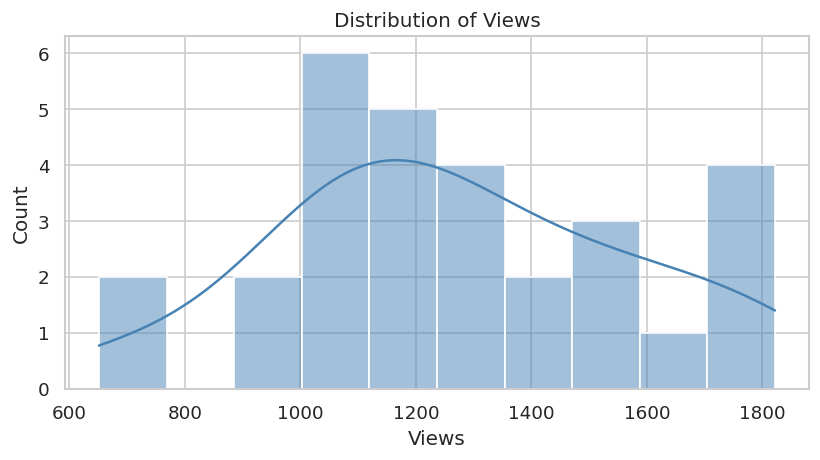

In [6]:
print(netflix_df_clean['Views'].describe())

plt.figure(figsize=(7,4))
sns.histplot(netflix_df_clean['Views'], bins=10, kde=True, color='steelblue')
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Views over time
A time-series plot to see any trend, spikes, or drops.

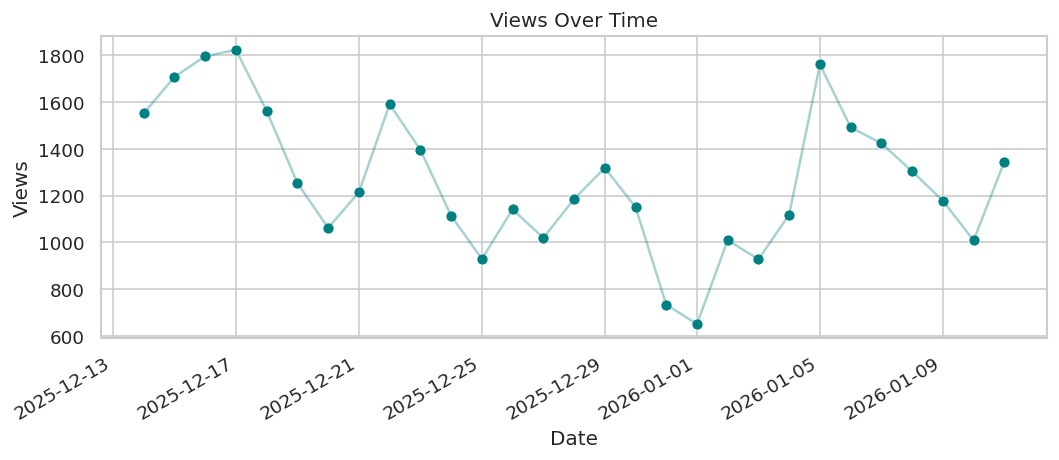

In [7]:
plt.figure(figsize=(9,4))
sns.scatterplot(data=netflix_df_clean, x='date', y='Views', color='teal', s=45)
sns.lineplot(data=netflix_df_clean, x='date', y='Views', color='teal', alpha=0.35)
plt.title('Views Over Time')
plt.xlabel('Date')
plt.ylabel('Views')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### Day-of-week analysis
Average Views by weekday and distribution via boxplot.

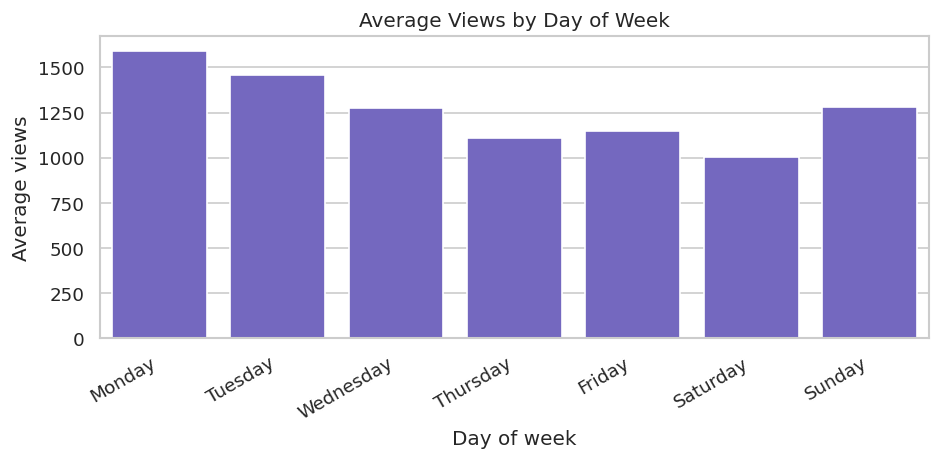

    day_name    Views
1     Monday  1593.75
5    Tuesday  1458.00
6  Wednesday  1273.25
4   Thursday  1111.00
0     Friday  1145.50
2   Saturday  1004.00
3     Sunday  1282.80


/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


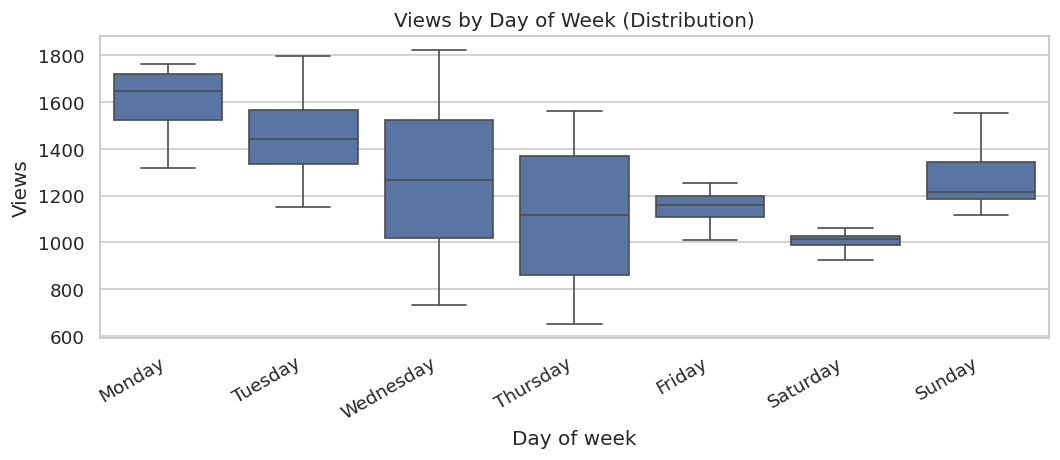

In [8]:
order_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Average by day
avg_by_day = netflix_df_clean.groupby('day_name', as_index=False)['Views'].mean()
avg_by_day['day_name'] = pd.Categorical(avg_by_day['day_name'], categories=order_days, ordered=True)
avg_by_day = avg_by_day.sort_values('day_name')

plt.figure(figsize=(8,4))
sns.barplot(data=avg_by_day, x='day_name', y='Views', color='slateblue')
plt.title('Average Views by Day of Week')
plt.xlabel('Day of week')
plt.ylabel('Average views')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print(avg_by_day)

# Distribution by day
plt.figure(figsize=(9,4))
sns.boxplot(data=netflix_df_clean, x='day_name', y='Views', order=order_days)
plt.title('Views by Day of Week (Distribution)')
plt.xlabel('Day of week')
plt.ylabel('Views')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### Correlations
We compute correlations between Views, time as an ordinal, and week number.

                 Views  date_ordinal      week
Views         1.000000     -0.376175  0.304458
date_ordinal -0.376175      1.000000 -0.855975
week          0.304458     -0.855975  1.000000


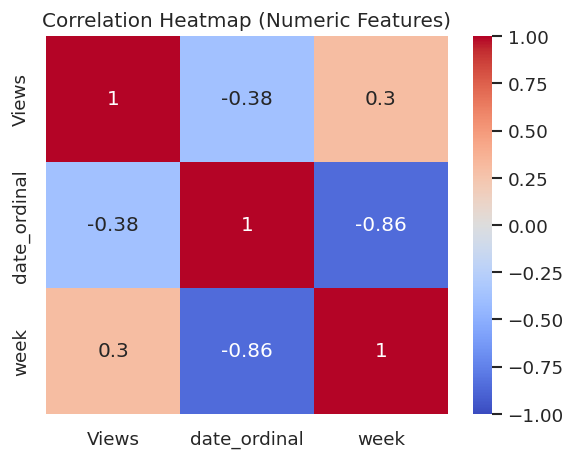

In [9]:
corr_mat = netflix_df_clean[['Views','date_ordinal','week']].corr(numeric_only=True)
print(corr_mat)

plt.figure(figsize=(5,4))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

### Extremes
We list the max and min Views days.

In [10]:
max_row = netflix_df_clean.loc[netflix_df_clean['Views'].idxmax(), ['date','Views','day_name']]
min_row = netflix_df_clean.loc[netflix_df_clean['Views'].idxmin(), ['date','Views','day_name']]

print(max_row)
print(min_row)

date        2025-12-17 00:00:00
Views                      1822
day_name              Wednesday
Name: 3, dtype: object
date        2026-01-01 00:00:00
Views                       651
day_name               Thursday
Name: 18, dtype: object


### Summary insights
The key takeaways from this EDA.

- Views show noticeable daily variability and an overall downtrend across the observed window.
- Monday and Tuesday have the highest average Views.
- No extreme outliers are flagged by common statistical rules.
